In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import shutil
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split




In [2]:

dataset_path = '/kaggle/input/gtsrb-german-traffic-sign'
train_path = '/kaggle/input/gtsrb-german-traffic-sign/Train'
trainPreprocessed_path = '/kaggle/input/gtsrb-german-traffic-sign/TrainPreprocessed'
test_path = '/kaggle/input/gtsrb-german-traffic-sign/Test'
meta_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Meta.csv')
train_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Train.csv')
test_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
os.listdir(dataset_path)

train_csv_path = '/kaggle/input/gtsrb-german-traffic-sign/Train.csv'
train_images_folder = os.path.dirname(train_csv_path)


In [3]:
class_counts = {}
class_dirs = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
for class_dir in class_dirs:
    class_path = os.path.join(train_path, class_dir)

    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = num_images

for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")


Class 7: 1440 images
Class 17: 1110 images
Class 19: 210 images
Class 22: 390 images
Class 2: 2250 images
Class 35: 1200 images
Class 23: 510 images
Class 10: 2010 images
Class 5: 1860 images
Class 36: 390 images
Class 20: 360 images
Class 27: 240 images
Class 41: 240 images
Class 39: 300 images
Class 32: 240 images
Class 25: 1500 images
Class 42: 240 images
Class 8: 1410 images
Class 38: 2070 images
Class 12: 2100 images
Class 0: 210 images
Class 31: 780 images
Class 34: 420 images
Class 18: 1200 images
Class 28: 540 images
Class 16: 420 images
Class 13: 2160 images
Class 26: 600 images
Class 15: 630 images
Class 3: 1410 images
Class 1: 2220 images
Class 30: 450 images
Class 14: 780 images
Class 4: 1980 images
Class 9: 1470 images
Class 21: 330 images
Class 40: 360 images
Class 6: 420 images
Class 11: 1320 images
Class 37: 210 images
Class 33: 689 images
Class 29: 270 images
Class 24: 270 images


In [4]:
import os
from PIL import Image

# Preprocessing
def resize_and_save_images(input_dir, output_dir, image_size):
    """
    Resize images in the input directory and save them in the output directory.

    Parameters:
        input_dir (str): Path to the input directory containing class subdirectories.
        output_dir (str): Path to the output directory to save resized images.
        image_size (int): Desired size for resizing (image_size x image_size).
    """
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    resample_filter = Image.Resampling.LANCZOS
    for class_name in os.listdir(input_dir):
        class_input_dir = os.path.join(input_dir, class_name)
        class_output_dir = os.path.join(output_dir, class_name)

        # Skip non-directory entries
        if not os.path.isdir(class_input_dir):
            print(f"Skipping non-directory entry: {class_input_dir}")
            continue

        # Ensure class-specific output directory exists
        os.makedirs(class_output_dir, exist_ok=True)

        print(f"Processing class: {class_name}")
        for img_name in os.listdir(class_input_dir):
            img_input_path = os.path.join(class_input_dir, img_name)
            img_output_path = os.path.join(class_output_dir, img_name)

            try:
                # Open, resize, and save the image
                with Image.open(img_input_path) as img:
                    img = img.resize((image_size, image_size), resample_filter)
                    img.save(img_output_path)
            except Exception as e:
                print(f"Error processing image {img_input_path}: {e}")

# Example Usage
input_directory = "/kaggle/input/gtsrb-german-traffic-sign/Train"
output_directory = "/kaggle/working/train_preprocessed"  # Use writable directory
image_size = 32

resize_and_save_images(input_directory, output_directory, image_size)


Processing class: 7
Processing class: 17
Processing class: 19
Processing class: 22
Processing class: 2
Processing class: 35
Processing class: 23
Processing class: 10
Processing class: 5
Processing class: 36
Processing class: 20
Processing class: 27
Processing class: 41
Processing class: 39
Processing class: 32
Processing class: 25
Processing class: 42
Processing class: 8
Processing class: 38
Processing class: 12
Processing class: 0
Processing class: 31
Processing class: 34
Processing class: 18
Processing class: 28
Processing class: 16
Processing class: 13
Processing class: 26
Processing class: 15
Processing class: 3
Processing class: 1
Processing class: 30
Processing class: 14
Processing class: 4
Processing class: 9
Processing class: 21
Processing class: 40
Processing class: 6
Processing class: 11
Processing class: 37
Processing class: 33
Processing class: 29
Processing class: 24


In [5]:
def resize_and_save_test_images(input_dir, output_dir, image_size):
    """
    Resize and save images from the test directory without class subdirectories.

    Parameters:
        input_dir (str): Path to the directory containing test images.
        output_dir (str): Path to save the resized images.
        image_size (int): Desired size for resizing images (image_size x image_size).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    resample_filter = Image.Resampling.LANCZOS

    print(f"Processing test images in: {input_dir}")
    for img_name in os.listdir(input_dir):
        img_input_path = os.path.join(input_dir, img_name)
        img_output_path = os.path.join(output_dir, img_name)
        if not os.path.isfile(img_input_path):
            print(f"Skipping non-file entry: {img_input_path}")
            continue
        try:
            with Image.open(img_input_path) as img:
                img = img.resize((image_size, image_size), resample_filter)
                img.save(img_output_path)
         
        except Exception as e:
            print(f"Error processing image {img_input_path}: {e}")
test_input_directory = test_path
test_output_directory = '/kaggle/working/test_preprocessed'
image_size = 32

resize_and_save_test_images(test_input_directory, test_output_directory, image_size)


Processing test images in: /kaggle/input/gtsrb-german-traffic-sign/Test
Error processing image /kaggle/input/gtsrb-german-traffic-sign/Test/GT-final_test.csv: cannot identify image file '/kaggle/input/gtsrb-german-traffic-sign/Test/GT-final_test.csv'


In [6]:
preprocessed_train =output_directory
preprocessed_test = test_output_directory

In [7]:
def check_image_sizes(directory, expected_size, has_classes=True):
    """
    Check if all images in the directory have the expected size.

    Parameters:
        directory (str): Path to the directory to check.
        expected_size (tuple): Expected (width, height) of the images.
        has_classes (bool): If True, expects subdirectories for classes (train directory structure).
                            If False, processes all images directly (test directory structure).

    Returns:
        None
    """
    incorrect_images = []
    total_images = 0

    if has_classes:
        # Iterate through class subdirectories
        for class_name in os.listdir(directory):
            class_dir = os.path.join(directory, class_name)
            if not os.path.isdir(class_dir):
                continue  # Skip if not a directory
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                total_images += 1
                try:
                    with Image.open(img_path) as img:
                        if img.size != expected_size:
                            incorrect_images.append((img_path, img.size))
                except Exception as e:
                    print(f"Error opening image {img_path}: {e}")
    else:
        # Process all images directly
        for img_name in os.listdir(directory):
            img_path = os.path.join(directory, img_name)
            if not os.path.isfile(img_path):
                continue  # Skip non-file entries
            total_images += 1
            try:
                with Image.open(img_path) as img:
                    if img.size != expected_size:
                        incorrect_images.append((img_path, img.size))
            except Exception as e:
                print(f"Error opening image {img_path}: {e}")

    # Output results
    if not incorrect_images:
        print(f"All {total_images} images have the size {expected_size}.")
    else:
        print(f"Total images checked: {total_images}")
        print(f"Images with incorrect size:")
        for img_info in incorrect_images:
            print(f"{img_info[0]} has size {img_info[1]}, expected {expected_size}")
        print(f"Number of images with incorrect size: {len(incorrect_images)}")


In [8]:
desired_size = (32, 32)
check_image_sizes(preprocessed_train, desired_size, has_classes=True)
check_image_sizes(preprocessed_test, desired_size, has_classes=False)


All 39209 images have the size (32, 32).
All 12630 images have the size (32, 32).


In [9]:
def normalize_and_save_images_to_01(input_dir, output_dir, has_classes=True, batch_size=64):
    """
    Normalize pixel values to [0, 1] and save images from a directory in batches.

    Parameters:
        input_dir (str): Path to the input directory containing images.
        output_dir (str): Path to the output directory to save normalized images.
        has_classes (bool): If True, expects class subdirectories (train directory).
                            If False, processes all images directly (test directory).
        batch_size (int): Number of images to process per batch.

    Returns:
        None
    """
    os.makedirs(output_dir, exist_ok=True)

    transform = transforms.Compose([
        transforms.ToTensor()  # Converts to [0, 1]
    ])

    def process_batch(image_paths, output_paths):
        for img_path, save_path in zip(image_paths, output_paths):
            try:
                with Image.open(img_path).convert('RGB') as img:
                    normalized_tensor = transform(img)
                    normalized_img_pil = transforms.ToPILImage()(normalized_tensor)
                    normalized_img_pil.save(save_path)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    if has_classes:
        # Process class subdirectories
        for class_entry in tqdm(os.scandir(input_dir), desc="Processing classes"):
            if not class_entry.is_dir():
                continue
            class_name = class_entry.name
            class_input_dir = class_entry.path
            class_output_dir = os.path.join(output_dir, class_name)
            os.makedirs(class_output_dir, exist_ok=True)

            # Collect image paths in batches
            image_paths = []
            output_paths = []
            for img_entry in os.scandir(class_input_dir):
                if img_entry.is_file():
                    image_paths.append(img_entry.path)
                    output_paths.append(os.path.join(class_output_dir, img_entry.name))

                # Process a batch
                if len(image_paths) >= batch_size:
                    process_batch(image_paths, output_paths)
                    image_paths = []
                    output_paths = []

            # Process remaining images
            if image_paths:
                process_batch(image_paths, output_paths)
    else:
        # Process all images directly
        image_paths = []
        output_paths = []
        for img_entry in tqdm(os.scandir(input_dir), desc="Processing test images"):
            if img_entry.is_file():
                image_paths.append(img_entry.path)
                output_paths.append(os.path.join(output_dir, img_entry.name))

            # Process a batch
            if len(image_paths) >= batch_size:
                process_batch(image_paths, output_paths)
                image_paths = []
                output_paths = []

        # Process remaining images
        if image_paths:
            process_batch(image_paths, output_paths)


In [10]:
normalize_and_save_images_to_01(preprocessed_train, preprocessed_train, has_classes=True, batch_size=64)

Processing classes: 43it [00:34,  1.24it/s]


In [11]:
normalize_and_save_images_to_01(preprocessed_test, preprocessed_test, has_classes=False, batch_size=64)

Processing test images: 12630it [00:11, 1131.69it/s]


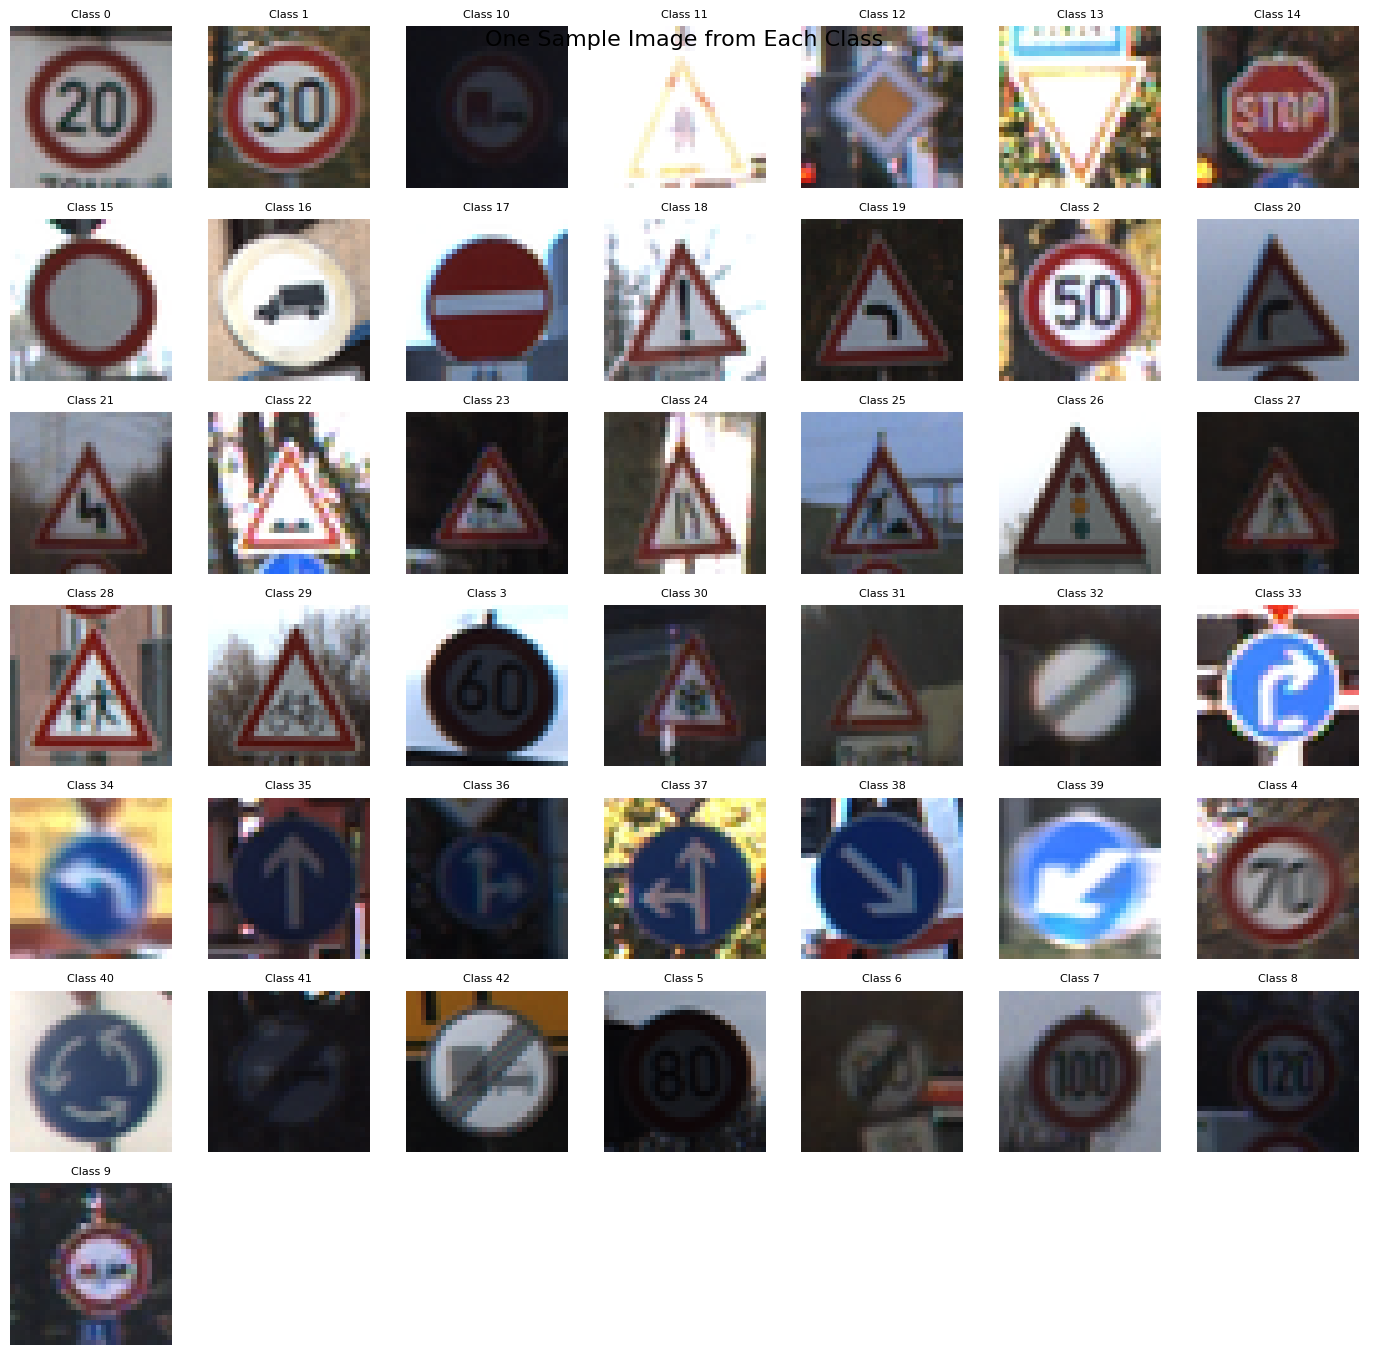

In [12]:
def display_one_sample_per_class_grid(train_path, grid_size=(7, 7)):
    """
    Display one sample image from each class in a 7x7 grid layout.

    Parameters:
        train_path (str): Path to the training dataset folder.
        grid_size (tuple): Grid size (rows, cols) for displaying images.
    """
    class_dirs = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
    class_dirs.sort()  # Sort the class directories for consistent visualization

    num_classes = len(class_dirs)
    rows, cols = grid_size
    image_size = 32  # Resize images to a smaller size for display

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle("One Sample Image from Each Class", fontsize=16, y=0.95)

    for idx, class_dir in enumerate(class_dirs):
        if idx >= rows * cols:
            break
        class_path = os.path.join(train_path, class_dir)
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        if len(image_files) > 0:
            image_path = os.path.join(class_path, image_files[0])
            image = Image.open(image_path).resize((image_size, image_size))

            row, col = divmod(idx, cols)
            ax = axes[row, col]
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Class {class_dir}", fontsize=8)

    # Turn off unused axes
    for idx in range(num_classes, rows * cols):
        row, col = divmod(idx, cols)
        axes[row, col].axis('off')

    plt.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust spacing between plots
    plt.tight_layout()
    plt.show()

# Display one sample image from each class in a 7x7 grid
display_one_sample_per_class_grid(preprocessed_train, grid_size=(7, 7))


Class Counts Before Augmentation:
Class 0: 210 images
Class 1: 2220 images
Class 2: 2250 images
Class 3: 1410 images
Class 4: 1980 images
Class 5: 1860 images
Class 6: 420 images
Class 7: 1440 images
Class 8: 1410 images
Class 9: 1470 images
Class 10: 2010 images
Class 11: 1320 images
Class 12: 2100 images
Class 13: 2160 images
Class 14: 780 images
Class 15: 630 images
Class 16: 420 images
Class 17: 1110 images
Class 18: 1200 images
Class 19: 210 images
Class 20: 360 images
Class 21: 330 images
Class 22: 390 images
Class 23: 510 images
Class 24: 270 images
Class 25: 1500 images
Class 26: 600 images
Class 27: 240 images
Class 28: 540 images
Class 29: 270 images
Class 30: 450 images
Class 31: 780 images
Class 32: 240 images
Class 33: 689 images
Class 34: 420 images
Class 35: 1200 images
Class 36: 390 images
Class 37: 210 images
Class 38: 2070 images
Class 39: 300 images
Class 40: 360 images
Class 41: 240 images
Class 42: 240 images


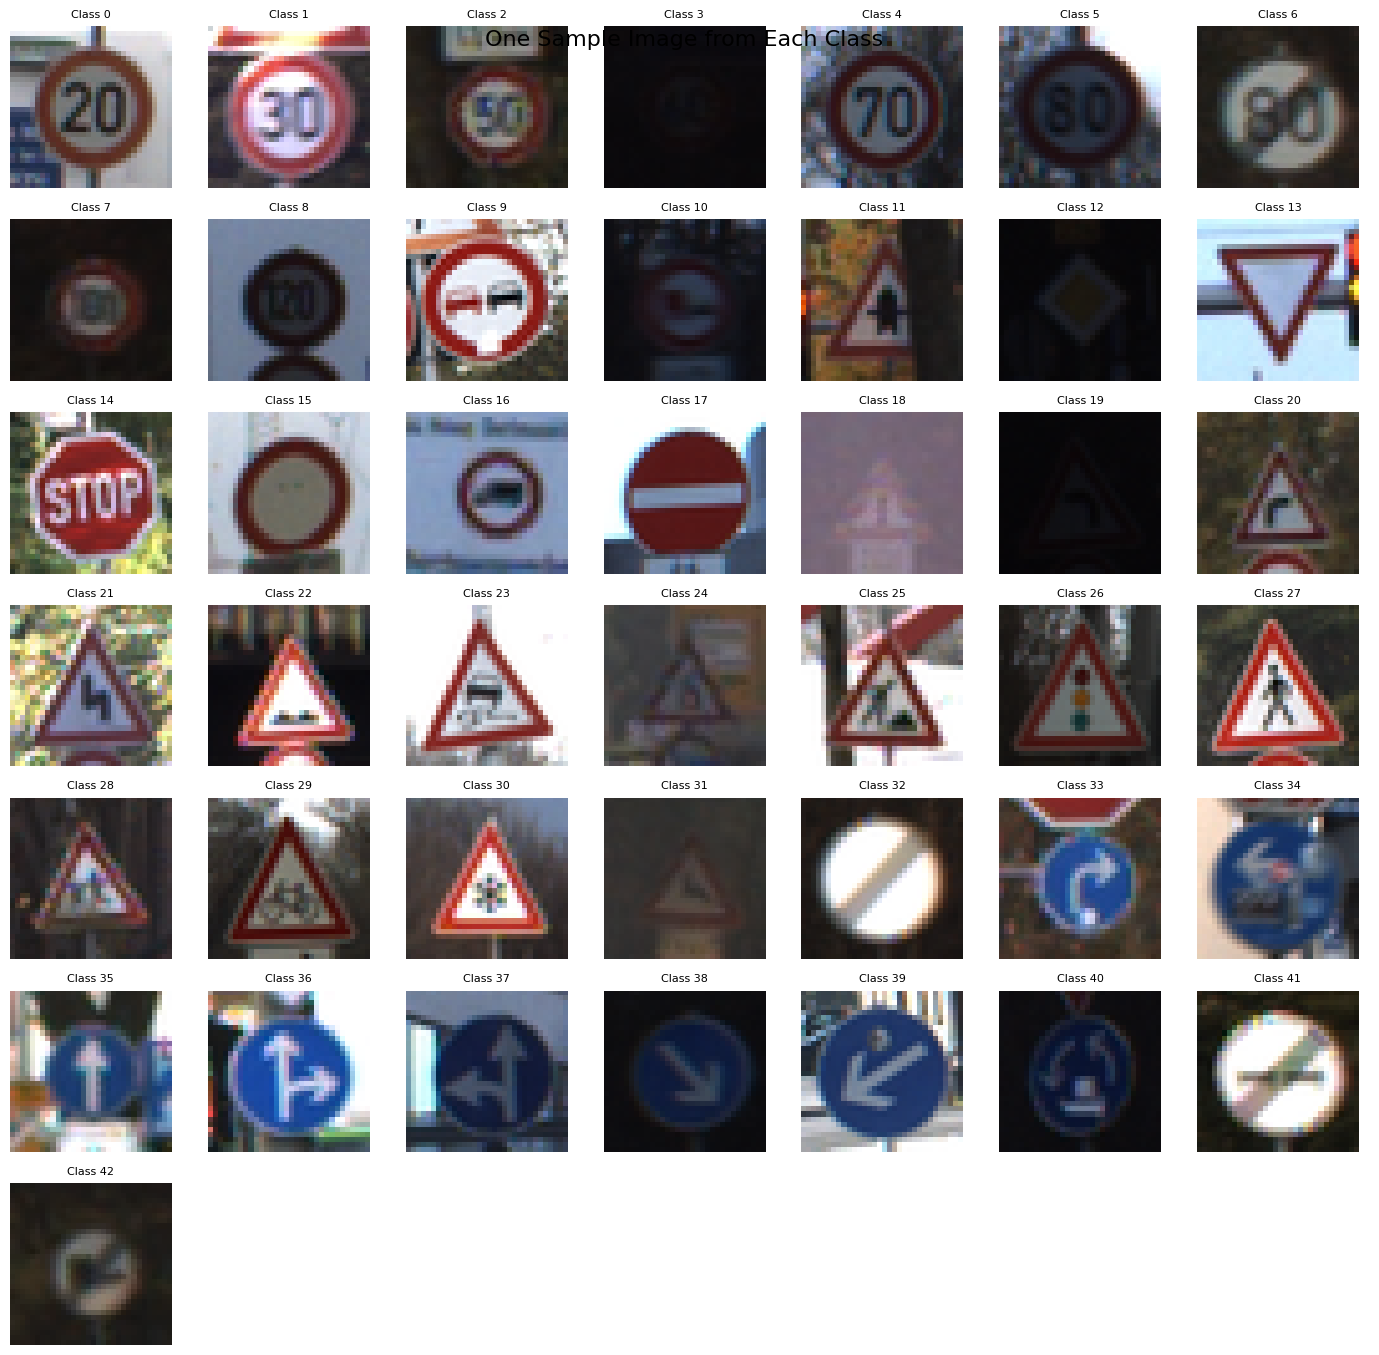

Augmenting Class 21: 100%|█████████▉| 1919/1920 [00:03<00:00, 611.72it/s]



Class Counts After Augmentation:
Class 0: 2250 images
Class 1: 2250 images
Class 2: 2250 images
Class 3: 2250 images
Class 4: 2250 images
Class 5: 2250 images
Class 6: 2250 images
Class 7: 2250 images
Class 8: 2250 images
Class 9: 2250 images
Class 10: 2250 images
Class 11: 2250 images
Class 12: 2250 images
Class 13: 2250 images
Class 14: 2250 images
Class 15: 2250 images
Class 16: 2250 images
Class 17: 2250 images
Class 18: 2250 images
Class 19: 2250 images
Class 20: 2250 images
Class 21: 2250 images
Class 22: 2250 images
Class 23: 2250 images
Class 24: 2250 images
Class 25: 2250 images
Class 26: 2250 images
Class 27: 2250 images
Class 28: 2250 images
Class 29: 2250 images
Class 30: 2250 images
Class 31: 2250 images
Class 32: 2250 images
Class 33: 2250 images
Class 34: 2250 images
Class 35: 2250 images
Class 36: 2250 images
Class 37: 2250 images
Class 38: 2250 images
Class 39: 2250 images
Class 40: 2250 images
Class 41: 2250 images
Class 42: 2250 images


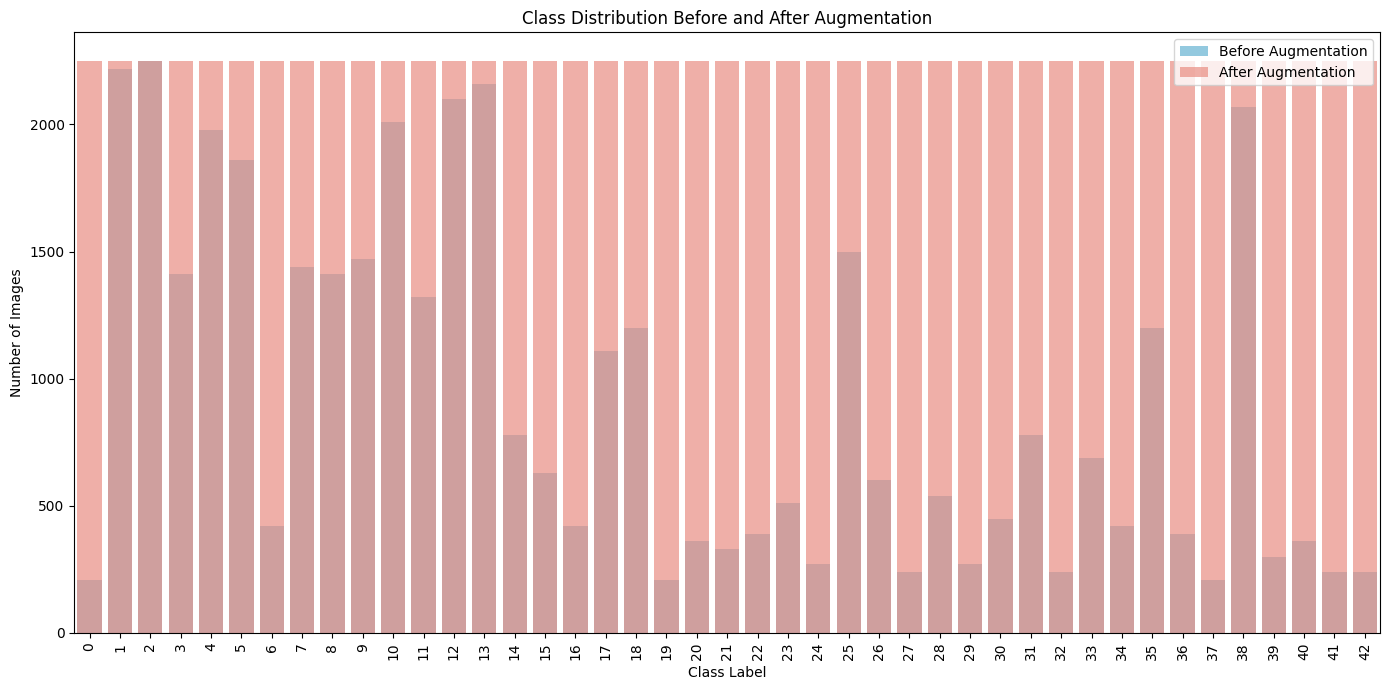

In [13]:
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from torchvision import transforms

# Define paths
train_path = "/kaggle/working/train_preprocessed"
augmented_data_path = "/kaggle/working/Augmented_Train"

# ================================
# 1. Calculate Class Counts Before Augmentation
# ================================
def calculate_class_counts(train_path, class_dirs):
    class_counts = {}
    for class_dir in class_dirs:
        class_path = os.path.join(train_path, class_dir)
        if os.path.exists(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        else:
            num_images = 0  # Handle missing directories
        class_counts[class_dir] = num_images
    return class_counts

# Get list of class directories
class_dirs = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# Calculate class counts before augmentation
class_counts_before = calculate_class_counts(train_path, class_dirs)

# Display class counts before augmentation
print("========================================")
print("Class Counts Before Augmentation:")
print("========================================")
for class_label, count in sorted(class_counts_before.items(), key=lambda x: int(x[0])):
    print(f"Class {class_label}: {count} images")

# ================================
# 2. Display One Sample Image per Class in a Grid
# ================================
def display_one_sample_per_class_grid(train_path, class_dirs, grid_size=(7, 7)):
    class_dirs_sorted = sorted(class_dirs, key=lambda x: int(x))  # Sort numerically for consistent visualization
    num_classes = len(class_dirs_sorted)
    rows, cols = grid_size
    image_size = 32  # Resize images for display

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle("One Sample Image from Each Class", fontsize=16, y=0.95)

    for idx, class_dir in enumerate(class_dirs_sorted):
        if idx >= rows * cols:
            break
        class_path = os.path.join(train_path, class_dir)
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        if len(image_files) > 0:
            image_file = np.random.choice(image_files)
            image_path = os.path.join(class_path, image_file)
            try:
                image = Image.open(image_path).resize((image_size, image_size))
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                continue

            row, col = divmod(idx, cols)
            ax = axes[row, col]
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Class {class_dir}", fontsize=8)

    for idx in range(num_classes, rows * cols):
        row, col = divmod(idx, cols)
        axes[row, col].axis('off')

    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.tight_layout()
    plt.show()

# Display one sample image from each class
display_one_sample_per_class_grid(train_path, class_dirs, grid_size=(7, 7))

# ================================
# 3. Define Data Augmentation Techniques
# ================================
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

# Clean augmented data directory to prevent duplication
if os.path.exists(augmented_data_path):
    shutil.rmtree(augmented_data_path)
os.makedirs(augmented_data_path, exist_ok=True)

# ================================
# 4. Apply Augmentation
# ================================
original_max_count = max(class_counts_before.values())
target_count = original_max_count

def augment_class_images(class_dir, class_path, augmented_class_path, current_count, target_count, augmentation_transforms):
    images_needed = target_count - current_count
    if images_needed <= 0:
        return 0

    augmented_count = 0
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and not f.startswith('aug_')]

    if not image_files:
        print(f"No images found in class {class_dir}. Skipping augmentation.")
        return augmented_count

    os.makedirs(augmented_class_path, exist_ok=True)

    for i in tqdm(range(images_needed), desc=f"Augmenting Class {class_dir}"):
        image_file = np.random.choice(image_files)
        image_path = os.path.join(class_path, image_file)

        try:
            image = Image.open(image_path).convert('RGB')
            augmented_image = augmentation_transforms(image)
            augmented_image = transforms.ToPILImage()(augmented_image)

            augmented_filename = f"aug_{augmented_count}_{image_file}"
            augmented_image.save(os.path.join(augmented_class_path, augmented_filename))
            augmented_count += 1
        except Exception as e:
            print(f"Error augmenting image {image_path}: {e}")
            continue

        if augmented_count >= images_needed:
            break

    return augmented_count

# Apply augmentation to classes with fewer samples
augmented_counts = {}
for class_dir, count in class_counts_before.items():
    if count < target_count:
        class_path = os.path.join(train_path, class_dir)
        augmented_class_path = os.path.join(augmented_data_path, class_dir)
        augmented = augment_class_images(class_dir, class_path, augmented_class_path, count, target_count, augmentation_transforms)
        augmented_counts[class_dir] = augmented
    else:
        augmented_counts[class_dir] = 0

# ================================
# 5. Calculate Class Counts After Augmentation
# ================================
def calculate_augmented_total_counts(original_counts, augmented_path, class_dirs):
    augmented_counts = {}
    for class_dir in class_dirs:
        augmented_class_path = os.path.join(augmented_path, class_dir)
        if os.path.exists(augmented_class_path):
            augmented_count = len([f for f in os.listdir(augmented_class_path) if os.path.isfile(os.path.join(augmented_class_path, f))])
        else:
            augmented_count = 0
        augmented_counts[class_dir] = augmented_count

    combined_counts = {}
    for class_dir in class_dirs:
        combined_counts[class_dir] = original_counts.get(class_dir, 0) + augmented_counts.get(class_dir, 0)
    return combined_counts

class_counts_after = calculate_augmented_total_counts(class_counts_before, augmented_data_path, class_dirs)

print("\n========================================")
print("Class Counts After Augmentation:")
print("========================================")
for class_label, count in sorted(class_counts_after.items(), key=lambda x: int(x[0])):
    print(f"Class {class_label}: {count} images")

# ================================
# 6. Visualize Class Distribution
# ================================
before_counts = pd.Series(class_counts_before).astype(int).sort_index()
after_counts = pd.Series(class_counts_after).astype(int).sort_index()

plt.figure(figsize=(14, 7))
sns.barplot(x=before_counts.index.astype(int), y=before_counts.values, color='skyblue', label='Before Augmentation')
sns.barplot(x=after_counts.index.astype(int), y=after_counts.values, color='salmon', label='After Augmentation', alpha=0.7)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution Before and After Augmentation')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [14]:
train_base_dir = "/kaggle/input/gtsrb-german-traffic-sign"
test_base_dir ="/kaggle/input/gtsrb-german-traffic-sign"


# File paths for CSV files

train_csv_path = '/kaggle/input/gtsrb-german-traffic-sign/Train.csv'
test_csv_path = '/kaggle/input/gtsrb-german-traffic-sign/Test.csv'

# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Define hyperparameters
num_classes = 43  # Update based on your dataset
batch_size = 16
num_epochs = 10
learning_rate = 0.001
validation_split = 0.2  # Use 20% of the training data for validation

# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None):
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Concatenate base directory with relative image path
        img_path = os.path.join(self.base_dir, str(self.dataframe.iloc[idx, -1]))
        label = int(self.dataframe.iloc[idx, -2])  # Ensure this is the correct column for labels
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise ValueError(f"Image not found: {img_path}")
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create Datasets
full_train_dataset = CustomDataset(train_df, train_base_dir, transform=train_transforms)
test_dataset = CustomDataset(test_df, test_base_dir, transform=test_transforms)

# Split Training Dataset into Training and Validation Sets
train_size = int((1 - validation_split) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Pretrained MobileNetV2 Model
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Modify the Classifier for the Number of Classes in the Dataset
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move the Model to GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_accuracy = 100. * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%")

# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Testing Function
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Test the Model
test_model(model, test_loader, device)

# Save the Trained Model
torch.save(model.state_dict(), "mobilenet_v2_traffic_signs.pth")


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 153MB/s]


Using device: cuda


Epoch 1/10: 100%|██████████| 1961/1961 [03:01<00:00, 10.82it/s]


Epoch 1, Loss: 0.4346, Accuracy: 86.49%
Validation Loss: 0.1407, Accuracy: 94.76%


Epoch 2/10: 100%|██████████| 1961/1961 [03:03<00:00, 10.66it/s]


Epoch 2, Loss: 0.1731, Accuracy: 94.01%
Validation Loss: 0.1331, Accuracy: 95.70%


Epoch 3/10: 100%|██████████| 1961/1961 [02:59<00:00, 10.92it/s]


Epoch 3, Loss: 0.1191, Accuracy: 96.07%
Validation Loss: 0.1708, Accuracy: 94.08%


Epoch 4/10: 100%|██████████| 1961/1961 [03:01<00:00, 10.83it/s]


Epoch 4, Loss: 0.1025, Accuracy: 96.74%
Validation Loss: 0.0516, Accuracy: 98.14%


Epoch 5/10: 100%|██████████| 1961/1961 [03:00<00:00, 10.88it/s]


Epoch 5, Loss: 0.0807, Accuracy: 97.34%
Validation Loss: 0.0731, Accuracy: 97.68%


Epoch 6/10: 100%|██████████| 1961/1961 [03:01<00:00, 10.83it/s]


Epoch 6, Loss: 0.0715, Accuracy: 97.70%
Validation Loss: 0.0581, Accuracy: 98.27%


Epoch 7/10: 100%|██████████| 1961/1961 [03:01<00:00, 10.80it/s]


Epoch 7, Loss: 0.0699, Accuracy: 97.77%
Validation Loss: 0.0726, Accuracy: 97.74%


Epoch 8/10: 100%|██████████| 1961/1961 [02:58<00:00, 10.98it/s]


Epoch 8, Loss: 0.0608, Accuracy: 98.00%
Validation Loss: 0.0541, Accuracy: 98.27%


Epoch 9/10: 100%|██████████| 1961/1961 [02:59<00:00, 10.94it/s]


Epoch 9, Loss: 0.0514, Accuracy: 98.26%
Validation Loss: 0.0304, Accuracy: 99.15%


Epoch 10/10: 100%|██████████| 1961/1961 [03:00<00:00, 10.87it/s]


Epoch 10, Loss: 0.0499, Accuracy: 98.44%
Validation Loss: 0.0520, Accuracy: 98.48%


Testing: 100%|██████████| 790/790 [00:49<00:00, 15.90it/s]

Test Accuracy: 95.68%


In [15]:
class FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Parse directory structure
        for label, class_dir in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise ValueError(f"Image not found: {img_path}")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define hyperparameters
num_classes = 43  # Update based on your dataset
batch_size = 16
num_epochs = 10
learning_rate = 0.001
validation_split = 0.2  # Use 20% of the training data for validation

# Data Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset Paths
train_base_dir ='/kaggle/working/Augmented_Train'
test_base_dir = '//kaggle/working/test_preprocessed'

# Create Datasets
full_train_dataset = FolderDataset(train_base_dir, transform=train_transforms)
test_dataset = FolderDataset(test_base_dir, transform=test_transforms)

# Split Training Dataset into Training and Validation Sets
train_size = int((1 - validation_split) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Pretrained MobileNetV2 Model
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Modify the Classifier for the Number of Classes in the Dataset
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move the Model to GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_accuracy = 100. * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%")

# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Testing Function
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")



Using device: cuda


Epoch 1/10: 100%|██████████| 2877/2877 [03:27<00:00, 13.86it/s]


Epoch 1, Loss: 0.4449, Accuracy: 85.35%
Validation Loss: 0.1419, Accuracy: 94.86%


Epoch 2/10: 100%|██████████| 2877/2877 [03:26<00:00, 13.90it/s]


Epoch 2, Loss: 0.1772, Accuracy: 94.05%
Validation Loss: 0.0885, Accuracy: 96.75%


Epoch 3/10: 100%|██████████| 2877/2877 [03:26<00:00, 13.91it/s]


Epoch 3, Loss: 0.1319, Accuracy: 95.69%
Validation Loss: 0.1057, Accuracy: 96.88%


Epoch 4/10: 100%|██████████| 2877/2877 [03:26<00:00, 13.90it/s]


Epoch 4, Loss: 0.1058, Accuracy: 96.53%
Validation Loss: 0.0580, Accuracy: 98.15%


Epoch 5/10: 100%|██████████| 2877/2877 [03:27<00:00, 13.90it/s]


Epoch 5, Loss: 0.0884, Accuracy: 97.11%
Validation Loss: 0.0366, Accuracy: 98.82%


Epoch 6/10: 100%|██████████| 2877/2877 [03:26<00:00, 13.90it/s]


Epoch 6, Loss: 0.0745, Accuracy: 97.59%
Validation Loss: 0.0351, Accuracy: 98.85%


Epoch 7/10: 100%|██████████| 2877/2877 [03:26<00:00, 13.90it/s]


Epoch 7, Loss: 0.0681, Accuracy: 97.83%
Validation Loss: 0.0586, Accuracy: 97.99%


Epoch 8/10: 100%|██████████| 2877/2877 [03:26<00:00, 13.90it/s]


Epoch 8, Loss: 0.0589, Accuracy: 98.03%
Validation Loss: 0.0633, Accuracy: 98.10%


Epoch 9/10: 100%|██████████| 2877/2877 [03:26<00:00, 13.91it/s]


Epoch 9, Loss: 0.0509, Accuracy: 98.34%
Validation Loss: 0.0471, Accuracy: 98.52%


Epoch 10/10: 100%|██████████| 2877/2877 [03:26<00:00, 13.91it/s]


Epoch 10, Loss: 0.0484, Accuracy: 98.42%
Validation Loss: 0.0408, Accuracy: 98.59%


Testing: 0it [00:00, ?it/s]


ZeroDivisionError: float division by zero

In [ ]:
torch.save(model.state_dict(), "mobilenet2_v2_traffic_signs.pth")

In [ ]:

# Test the Model
test_model(model, test_loader, device)